# Otimização de Anúncios

<div style="text-align:justify">
Uma empresa de anúncios digitais que obtém lucro com a venda dos produtos e serviços, precisa ser capaz de exibir o(s) anúncio(s) com maior taxa de conversão, dentre os vários anúncios em sua base. A seguir vamos ilustrar um cenário onde cada compra garante o valor <code>R$ 1,00 e cada exibição de um anúncio custa R$ 0,20</code>.
<br><br>
Devemos modelar uma solução que maximize o retorno financeiro com a exibição dos anúncios.
</div>

### Carregando Pacotes

<div style="text-align:justify">
A seguir vamos carregar os pacotes necessários para desenvolver nosso experimento. Estamos utilizando uma implementação do algoritmo Multi-armed Bandit (MaB), provida pelo pacote mablib. Um MaB é uma técnica de aprendizado por reforço que explora opções e escolhe suas ações a partir de uma política e uma recompensa.
</div>

In [1]:
from matplotlib import pyplot
from mablib.policy import *
from mablib.mab import *

import warnings

### Configurações

<div style="text-align:justify">
A seguir vamos atribuir algumas configurações para o ambiente de desenvolvimento. Vamos definir um valor fixo para semente aleatória (<i>seed</i>) e um tamanho default para plot de imagens (<code>15 x 8</code>).
</div>

In [2]:
seed = 42
random.seed(seed)
numpy.random.seed(seed)
warnings.filterwarnings('ignore')
pyplot.rcParams['figure.figsize'] = (15, 8)

### Simulação

<div style="text-align:justify">
Para simular um cenário fictício que descrevemos acima, vamos utilizar dados que respeitam uma <code>distribuição beta</code>, de modo que poucos anúncios terão alta probabilidade de serem clicados. Vamos definir também a quantidade de anúncios possíveis em 50 anúncios.
<br><br>
Para efeito de validação do método, vamos exibir o anúncio mais provável (<i>best bind</i>):
</div>

Best bind 12 with 0.5719167162987613 of expected gain


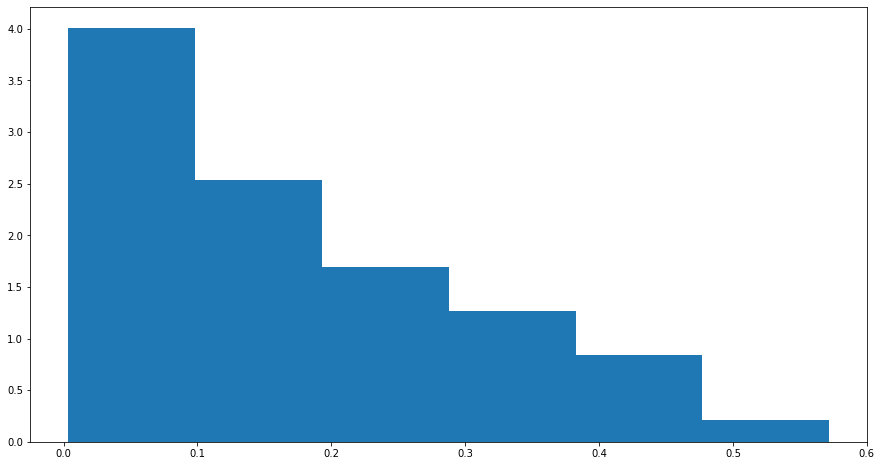

In [3]:
size = 50
arms = [random.betavariate(1.4, 5.4) for i in range(size)]
pyplot.hist(arms, density=True, bins=6)

# Best bind
idx = numpy.argmax(arms)
print('Best bind {} with {} of expected gain'.format(idx, arms[idx]))

<div style="text-align:justify">
Note que raramente um anúncio tem probabilidade de conversão <code>maior que 0.5</code>. A maior parte dos anúncios tem probabilidade de venda <code>menor que 0.1</code>. Nosso modelo deve ser capaz de oferecer mais frequentemente aqueles produtos com maior probabilidade de venda.
</div>

### Funções Auxiliares

<div style="text-align:justify">
Vamos definir duas funções auxiliares para nosso processo de experimentação: <code>plot_mab</code> e <code>plot_revenue</code>. A primeira será responsável por calcular as probabilidades de ocorrência de cada anúncio, selecionando o anúncio mais provável. Essa probabilidade será monitorada da recompensa média acumulada. A segunda função é responsável por calcular a receita obtida através da estratégia de publicação de anúncios.
</div>

In [4]:
def plot_mab(policy,title,xlabel='Episodes',ylabel='Cumulative Mean Reward',views=2000):
    mab = MultiArmedBandit(views=views, arms=arms, policy=policy, verbose=False)
    _, _ = mab.run()
    x, y, z = mab.cumulative_mean_reward()
    
    # plot cumulative mean reward
    pyplot.plot(x, y)
    pyplot.title(title)
    pyplot.xlabel(xlabel)
    pyplot.ylabel(ylabel)
    pyplot.show()
    
    return x, y, z

def plot_revenue(x,y,z,title='Accum Revenue',xlabel='Episodes',ylabel='Revenue',w=2000):
    c = numpy.cumsum([0.2] * len(x))
    z = z * 1

    pyplot.plot(x[:w], c[:w], label='cost')
    pyplot.plot(x[:w], z[:w], label='revenue')
    pyplot.title(title)
    pyplot.xlabel(xlabel)
    pyplot.ylabel(ylabel)
    pyplot.legend()
    pyplot.show()

### Random Policy

<div style="text-align:justify">
Para comparar o efeito que cada política de recompensa traz para nosso modelo, vamos definir o <i>baseline</i> a partir de uma seleção aleatória dos anúncios. Como a maior parte dos anúncios tem baixa probabilidade, estima-se que a probabilidade média e a receita acumulada sejam baixas.
</div>

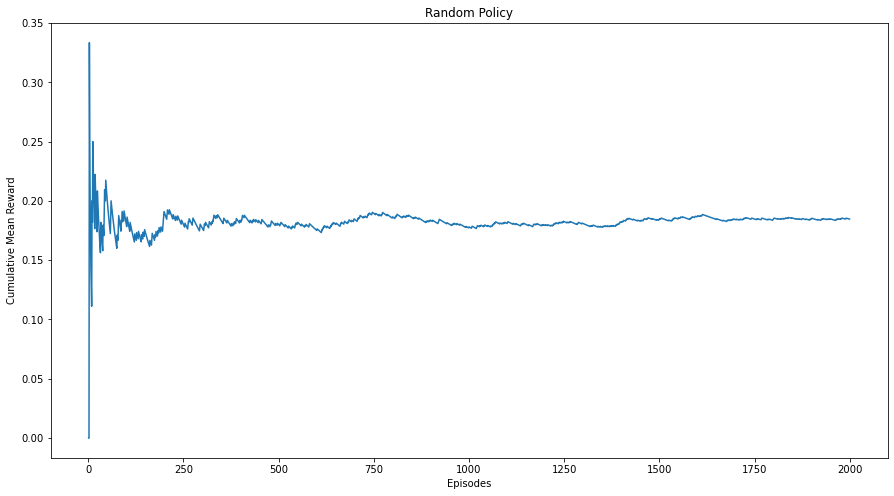

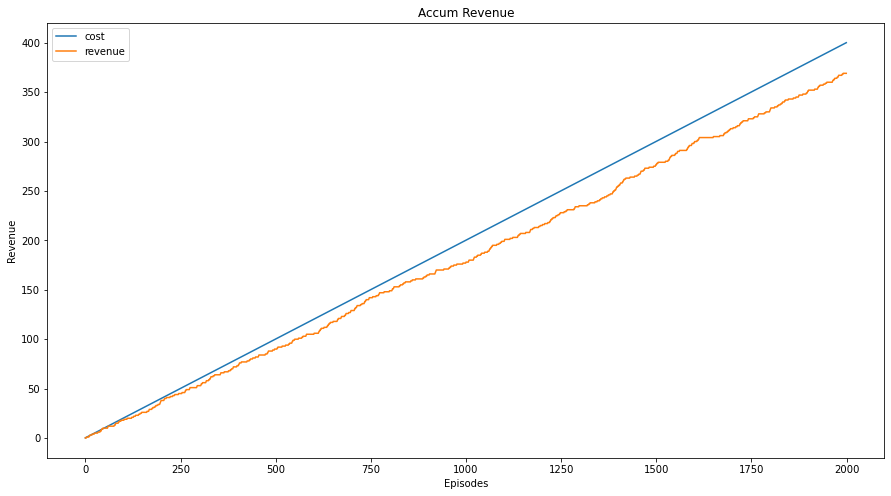

In [5]:
x, y, z = plot_mab(policy=RandomPolicy(size), title='Random Policy')
plot_revenue(x, y, z)

<div style="text-aling:justify">
Note que a probabilidade média de conversão ficou um pouco abaixo de 0.2, que significa vender um pouco menos do que o necessário para não levar prejuízo. O custo de 2 mil visualizações é de aproximadamente 400 reais (<code>0.20 centavos cada anúncio</code>), enquanto a receita é um pouco menor.
</div>

### Epsilon Greedy Policy

<div style="text-align:justify">
O <i>e-greedy</i> é uma das políticas de exploração mais simples de implementar e entender. Basicamente é definido um valor de epsilon qualquer que será a probabilidade de exploração aleatória dos anúncios, dessa forma, a política define que a cada iteração existe uma probabilidade epsilon de se escolher um arm aleatório, e uma probabilidade 1 - epsilon de se escolher o arm que tenha a recompensa média histórica maior, que no caso seria a melhor escolha.
<br><br>
Isso garante que os braços serão todos testados com uma certa frequência, e, caso a distribuição de recompensa mude ao longo do tempo o algoritmo vai se adaptando devido à exploração constante.
</div>

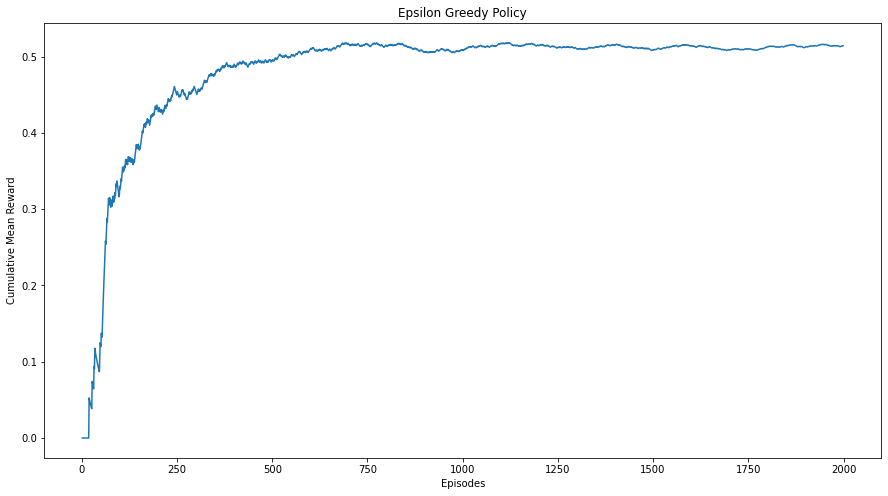

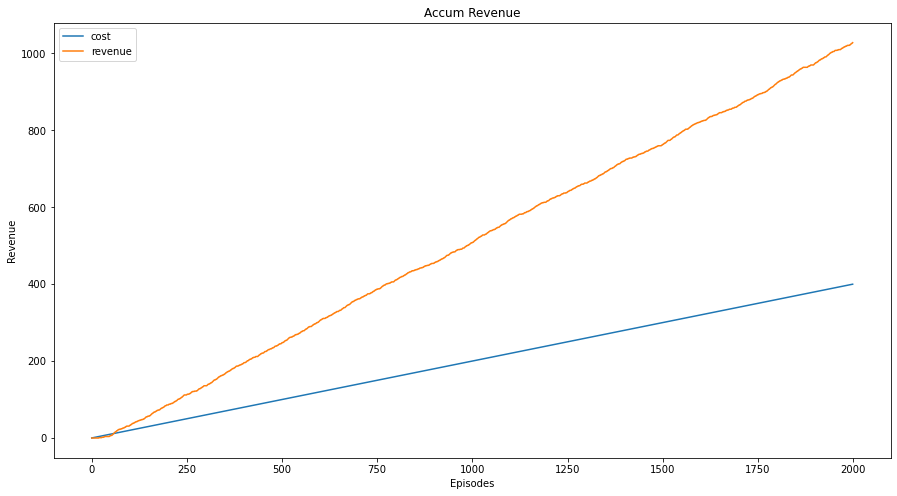

In [9]:
x, y, z = plot_mab(policy=EpsilonGreedyPolicy(size, epsilon=0.1), title='Epsilon Greedy Policy')
plot_revenue(x, y, z)

<div style="text-align:justify">
Note que a política de recompensa <i>e-greedy</i> encontra rapidamente o anúncio com maior probabilidade de conversão e passa a exibi-lo com prioridade, sem deixar de explorar outros anúncios.
</div>

### Thompson Sampling Policy

<div style="text-align:justify">
O Thompson Sampling parte da ideia de que queremos descobrir a distribuição de probabilidade real, então modelamos uma distribuição de probabilidade a partir das recompensas e usamos esse modelo para escolher o arm com a maior esperança de recompensa. Uma distribuição de probabilidade bem conhecida e bem versátil é a <code>Distribuição Beta</code>, que a depender dos parâmetros de <code>alpha</code> e <code>beta</code> assume um comportamento totalmente diferente.
<br><br>
Essa versatilidade em mudar de forma faz do Thompson Sampling um método muito adaptável, pois se ajustarmos os valores de <code>alpha</code> e <code>beta</code> de cada <i>arm</i> teremos uma distribuição de probabilidade diferente para cada <i>arm</i> e possivelmente próxima da real.
</div>

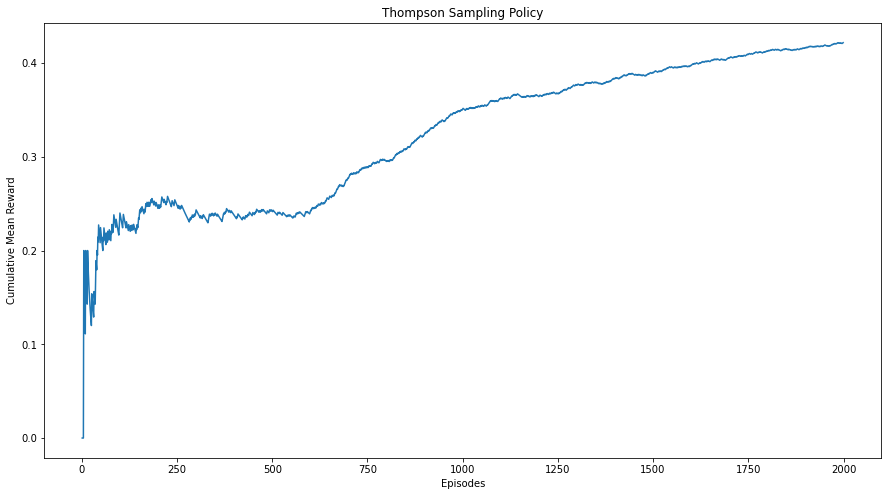

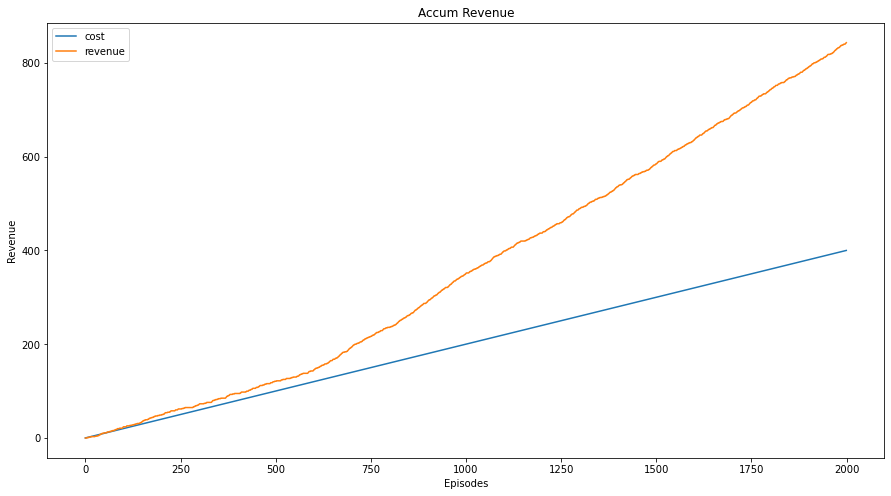

In [7]:
x, y, z = plot_mab(policy=ThompsonSamplingPolicy(size), title='Thompson Sampling Policy')
plot_revenue(x, y, z)

<div style="text-align:justify">
Neste caso específico, a política Thompson Sampling é mais interessante para ganhos a longo prazo, apresentando um comportamento de crescimento mesmo após um grande número de repetições.
</div>